In [1]:
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import transforms, datasets

from classifiers.NerveNet_NU_reduced import NerveNET, BinaryOut
from data_utils_NerveNet_NU import SegmentationData
from solver_NerveNet_NU import Solver
import transform_utils_NerveNet as tu
from dice_loss_NU import DiceLoss

%load_ext autoreload
%autoreload 2

The following calculates the **sizes of train, validation and test set**. Make sure it returns **True** by modifying the values in the dictionary 'nums'.

In [2]:
img_files = 'image_files_maskonly.txt'#'image_files.txt' #'image_files_maskonly.txt'
num_lines = sum(1 for line in open(img_files, 'r'))
num_lines = sum(1 for line in open(img_files, 'r'))
nums = {'num_train' : int(0.6*num_lines)+1,
        'num_val'   : int(0.2*num_lines),
        'num_test' : int(0.2*num_lines)}

print(nums, num_lines)
print(np.sum(list(nums.values())) == num_lines)

{'num_train': 758, 'num_val': 252, 'num_test': 252} 1262
True


**New in dataloader**: 
1. The dataloader has the new flag **binary_out**. If True, it will return a binary value that is if a nerve mask is contained in the target or not. Calling e.g. train_data[0] will return inputs and targets, where targets is now a dictionary with keys **'main'** and **'binary'**, if binary_out is True.
2. The text file that contains the image id's can now be in the git project directory.

In [9]:
input_dim = (1, 32, 32)

train_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.RandomHorizontalFlip(),
                               tu.RandomVerticalFlip(),                               
                               tu.ToTensor()])

val_transforms = tu.Compose([tu.Resize(input_dim[1::]),
                               tu.ToTensor()])


train_data = SegmentationData(img_files, transform = train_transforms, mode = 'train', **nums, binary_out = True)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

val_data = SegmentationData(img_files,  transform = val_transforms, mode = 'val', **nums)
val_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=4)

**New in classifier**: 
1. NerveNet has a new **binary_out** flag, too. If True, the forward pass will calculate a binary output. Similarly the output of the forward pass is a dictionary with keys 'main' and 'binary'.
2. The argument **upsample_unit** is a switch between simple upsampling with bilinear interpolation and transposed convolutional layers. Must be either **'Upsample'** or **'ConvTranspose2d'**. Default is 'Upsample'.
3. **Xavier Normal Initialization** is automatically applied to all NerveNet layers.

In [10]:
model = NerveNET(input_dim, num_classes = 2, weight_scale = 0.01, dropout = 0.05, 
                binary_out = True, upsample_unit='Upsample')
#model = torch.load("models/NerveNet_NU_2class.model")
#model.binary_out = True

In [11]:
#model.binary = BinaryOut(4, 4, torch.nn.Softmax(dim = 0), 2, weight_scale = True)
#model.binary

In [12]:
for param in list(model.parameters()):
    param.requires_grad = True

for param in list(model.binary.parameters()):
    param.requires_grad = False
#layers = [model.down1, model.down2, model.down3, model.down4, model.binary]
#for layer in layers:
#    for param in list(layer.parameters()):
#        param.requires_grad = True

In [13]:
#for param in list(model.parameters()):
#      print(param.requires_grad)


**New in solver**:
1. Solver exspects new **binary_out** argument. Here, it should be a float value, that gives the weight of the loss of the binary output. The main output is implicitly weighted with one, so that **binary_out** should be **smaller than one**. If **binary_out** is equal to **zero**, **no binary loss** will be computed.
2. Train and validation are two seperate functions which seems to be more memory efficient and clearly structured.
3. Printing loss and accuracy were wrapped in seperate functions, too, to further enhance readability of the code.

**New in DiceLoss**:
1. DiceLoss now calculates and automatically detects the loss on **doubleclass input** (Batchsize, Classes = 2, H, W) with single class target (Batchsize, Classes = 1, H, W) by inverting the target for Class = 0 and adding losses for both classes.
2. The argument **classweights** receives weights for losses from class 0 and class 1, respectively. Default is [1, 1].
3. **Singleclass input** still doable. E.g. initialize model with **num_classes = 1** will work.



In [ ]:
solver = Solver(optim_args={"lr": 0.00005, #0.0025, #1.e-3, #1.e-2
                            "betas": (0.9, 0.999),
                            "eps": 1e-8,
                            "weight_decay": 0.001},
                loss_func = DiceLoss(classweights = [0.01, 0.99]), binary_out = 0)

model.train()
outputs = solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=5)

START TRAIN.
|Iteration 10/950| TRAIN loss: 0.231
|Iteration 20/950| TRAIN loss: 0.227
|Iteration 30/950| TRAIN loss: 0.201
|Iteration 40/950| TRAIN loss: 0.228
|Iteration 50/950| TRAIN loss: 0.214
|Iteration 60/950| TRAIN loss: 0.216
|Iteration 70/950| TRAIN loss: 0.217
|Iteration 80/950| TRAIN loss: 0.208
|Iteration 90/950| TRAIN loss: 0.263
|Iteration 100/950| TRAIN loss: 0.243
|Iteration 110/950| TRAIN loss: 0.227
|Iteration 120/950| TRAIN loss: 0.206
|Iteration 130/950| TRAIN loss: 0.189
|Iteration 140/950| TRAIN loss: 0.170
|Iteration 150/950| TRAIN loss: 0.213
|Iteration 160/950| TRAIN loss: 0.277
|Iteration 170/950| TRAIN loss: 0.249
|Iteration 180/950| TRAIN loss: 0.251
|Iteration 190/950| TRAIN loss: 0.207
|Epoch 1/5| TRAIN acc: 0.699
|Epoch 1/5| VAL acc: 0.747
|Iteration 200/950| TRAIN loss: 0.183
|Iteration 210/950| TRAIN loss: 0.247
|Iteration 220/950| TRAIN loss: 0.203
|Iteration 230/950| TRAIN loss: 0.217
|Iteration 240/950| TRAIN loss: 0.186
|Iteration 250/950| TRAIN lo

In [ ]:
model.save("models/NerveNet_NU_2class.model")

In [15]:
img_files = 'image_files.txt'


test_data = SegmentationData(img_files,  transform = val_transforms, mode = 'test', **nums)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

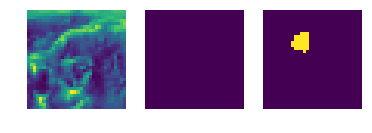

In [16]:
model.eval()

img, targets = test_data[116]

target = targets['main']
inputs = img.unsqueeze(0)
inputs = Variable(inputs)

model=model.cpu()

outputs = model.forward(inputs)
pred = outputs['main']
_, pred = torch.max(pred, 1)
binary_probs, binary = torch.max(outputs['binary'], 1)
#if binary.data.numpy() == 0:
#    pred = pred * 0
    
pred = pred.squeeze().data.cpu().numpy()
img=np.squeeze(img)
target = target.squeeze().numpy()

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(target)
ax[1].axis('off')
ax[2].imshow(pred)
ax[2].axis('off')
plt.show()

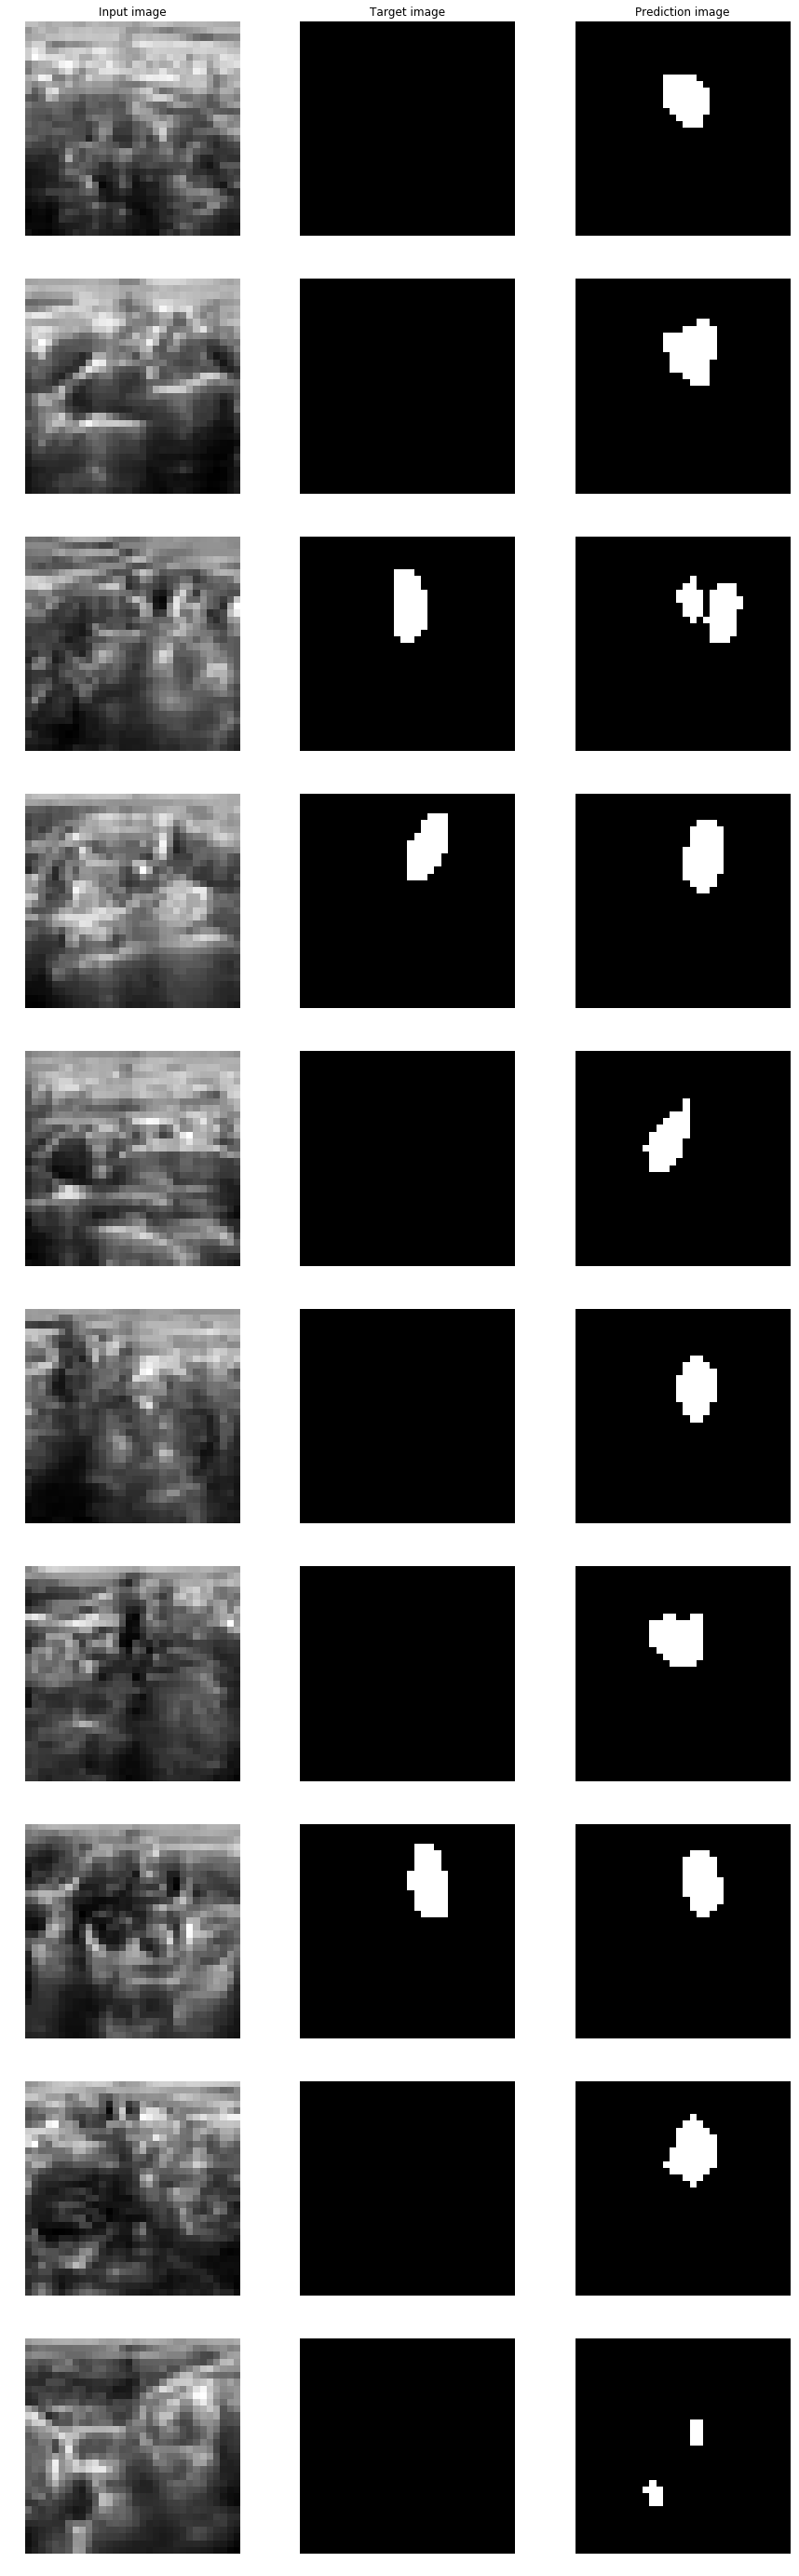

In [17]:
num_example_imgs = 10
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, targets) in enumerate(test_data[30:40]):
    
    target = targets['main']
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)

    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    binary_probs, binary = torch.max(outputs['binary'], 1)
    #if binary.data.numpy() == 0:
     #   pred = pred * 0
    pred = pred.squeeze().data.cpu().numpy()

    img=np.squeeze(img)
    target = target.squeeze().numpy()
        
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(target, cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred, cmap='gray')
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

In [ ]:
def dice_coefficient(ground_truth, predicted):
    gt = ground_truth
    p = predicted
    if np.sum(p) + np.sum(gt) == 0:
        return 1
    else:
        dice = np.sum(p[gt==1])*2.0 / (np.sum(p) + np.sum(gt))
        return dice

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets['main'])
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    outputs = model.forward(inputs)
    pred = outputs['main']
    _, pred = torch.max(pred, 1)
    _, binary = torch.max(outputs['binary'], 1)
    if binary.data.numpy() == 0:
        pred = pred * 0
    
    pred = pred.squeeze().data.cpu().numpy()
    test_scores.append(dice_coefficient(np.squeeze(targets.data.numpy()), pred))
    
np.mean(test_scores)

In [ ]:
x = np.array(test_scores)
x[x==1] = 0
np.argmax(x)

In [ ]:
x

In [ ]:
N = 0
mask = 0
for _, (img, target) in enumerate(test_data):
    N += target['main'].numel()
    mask += target['main'].sum()

In [ ]:
1 - mask/N